In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = '/kaggle/input/flipercorrectorvlg/pytorch/default/1/rotnet_model(1).pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import glob
from tqdm import tqdm
import gc
import numpy as np

# ================= CONFIGURATION =================
TRAIN_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos'
SAVE_PATH = 'roadmap_lite_model.pth'

BATCH_SIZE = 16          
IMG_SIZE = 256           
EPOCHS = 30
LR = 0.0003
T_STEPS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. COMPONENTS ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

# --- 2. ROADMAP LITE ---
class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)
    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 3. LOSSES ---
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features
        for m in vgg.modules():
            if isinstance(m, nn.ReLU): m.inplace = False
        self.blocks = nn.ModuleList([vgg[:4], vgg[4:9], vgg[9:16], vgg[16:23]])
        for param in self.parameters(): param.requires_grad = False
    def forward(self, x, y):
        loss = 0
        for block in self.blocks:
            x, y = block(x), block(y)
            loss += torch.mean(torch.abs(x - y))
        return loss

# --- 4. TRAINING ---
class RoadmapDataset(Dataset):
    def __init__(self, root, transform=None):
        self.clips = []
        self.transform = transform
        for vid in sorted(os.listdir(root)):
            path = os.path.join(root, vid)
            frames = sorted(glob.glob(os.path.join(path, '*.jpg')))
            if len(frames) < T_STEPS + 1: continue
            for i in range(len(frames) - T_STEPS):
                self.clips.append((frames[i:i+T_STEPS], frames[i+T_STEPS]))
    def __len__(self): return len(self.clips)
    def __getitem__(self, idx):
        in_paths, tgt_path = self.clips[idx]
        in_imgs = [self.transform(Image.open(p).convert('RGB')) for p in in_paths]
        tgt_img = self.transform(Image.open(tgt_path).convert('RGB'))
        return torch.stack(in_imgs), tgt_img

def train():
    torch.cuda.empty_cache(); gc.collect()
    print(f"Training ROADMAP LITE on {torch.cuda.device_count()} GPUs")
    
    tf = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
    loader = DataLoader(RoadmapDataset(TRAIN_DIR, tf), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    
    model = ROADMAP_LITE()
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    vgg_loss = VGGLoss().to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    l1_loss = nn.L1Loss(); l2_loss = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler()

    try:
        for epoch in range(EPOCHS):
            model.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}")
            
            # Epoch Accumulators
            epoch_loss = 0.0
            epoch_int = 0.0
            epoch_grad = 0.0
            epoch_noise = 0.0
            count = 0
            
            for inputs, target in loop:
                inputs, target = inputs.to(DEVICE), target.to(DEVICE)
                optimizer.zero_grad(set_to_none=True)
                
                with torch.cuda.amp.autocast():
                    pred = model(inputs)
                    
                    # Calculate Individual Losses
                    loss_int = l2_loss(pred, target)
                    loss_grad = l1_loss(pred, target)
                    loss_noise = vgg_loss(pred, target)
                    
                    total_loss = loss_int + loss_grad + loss_noise

                scaler.scale(total_loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                # Update Accumulators
                b_size = inputs.size(0)
                epoch_loss += total_loss.item() * b_size
                epoch_int += loss_int.item() * b_size
                epoch_grad += loss_grad.item() * b_size
                epoch_noise += loss_noise.item() * b_size
                count += b_size
                
                # Update Progress Bar with Breakdown
                loop.set_postfix(
                    T=total_loss.item(), 
                    Int=loss_int.item(), 
                    Grad=loss_grad.item(), 
                    Noise=loss_noise.item()
                )
            
            # Print Epoch Averages
            avg_loss = epoch_loss / count
            avg_int = epoch_int / count
            avg_grad = epoch_grad / count
            avg_noise = epoch_noise / count
            print(f"--> Ep {epoch+1} Avg: Total={avg_loss:.4f} | Int={avg_int:.4f} | Grad={avg_grad:.4f} | Noise={avg_noise:.4f}")
            
            torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("\n\n[!] Keyboard Interrupt detected. Stopping training...")

    # Save logic works for both successful finish AND Interrupt
    state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
    torch.save(state, SAVE_PATH)
    print(f"Model saved safely to {SAVE_PATH}")

if __name__ == "__main__":
    train()

Training ROADMAP LITE on 2 GPUs


/tmp/ipykernel_289/2548239020.py:130: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Ep 1:   0%|          | 0/572 [00:00<?, ?it/s]/tmp/ipykernel_289/2548239020.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Ep 1: 100%|██████████| 572/572 [09:47<00:00,  1.03s/it, Grad=0.0144, Int=0.000637, Noise=0.262, T=0.277]


--> Ep 1 Avg: Total=0.6830 | Int=0.0055 | Grad=0.0363 | Noise=0.6412


Ep 2: 100%|██████████| 572/572 [09:49<00:00,  1.03s/it, Grad=0.0188, Int=0.00106, Noise=0.382, T=0.401] 


--> Ep 2 Avg: Total=0.5451 | Int=0.0016 | Grad=0.0226 | Noise=0.5209


Ep 3: 100%|██████████| 572/572 [09:48<00:00,  1.03s/it, Grad=0.0191, Int=0.00126, Noise=0.344, T=0.364] 


--> Ep 3 Avg: Total=0.5069 | Int=0.0013 | Grad=0.0209 | Noise=0.4847


Ep 4: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.0164, Int=0.000721, Noise=0.292, T=0.309]


--> Ep 4 Avg: Total=0.4659 | Int=0.0012 | Grad=0.0194 | Noise=0.4453


Ep 5: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.0144, Int=0.000455, Noise=0.211, T=0.226]


--> Ep 5 Avg: Total=0.4458 | Int=0.0011 | Grad=0.0187 | Noise=0.4260


Ep 6: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.0161, Int=0.000759, Noise=0.424, T=0.441] 


--> Ep 6 Avg: Total=0.4317 | Int=0.0010 | Grad=0.0178 | Noise=0.4129


Ep 7: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.0277, Int=0.00177, Noise=0.721, T=0.75]   


--> Ep 7 Avg: Total=0.4248 | Int=0.0010 | Grad=0.0176 | Noise=0.4062


Ep 8: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.0193, Int=0.00111, Noise=0.436, T=0.456]  


--> Ep 8 Avg: Total=0.4202 | Int=0.0010 | Grad=0.0173 | Noise=0.4019


Ep 9: 100%|██████████| 572/572 [09:46<00:00,  1.03s/it, Grad=0.0202, Int=0.00121, Noise=0.467, T=0.488]  


--> Ep 9 Avg: Total=0.4164 | Int=0.0009 | Grad=0.0171 | Noise=0.3984


Ep 10: 100%|██████████| 572/572 [09:46<00:00,  1.02s/it, Grad=0.0174, Int=0.00201, Noise=0.242, T=0.261]  


--> Ep 10 Avg: Total=0.4129 | Int=0.0009 | Grad=0.0169 | Noise=0.3951


Ep 11: 100%|██████████| 572/572 [09:47<00:00,  1.03s/it, Grad=0.00864, Int=0.000283, Noise=0.18, T=0.189] 


--> Ep 11 Avg: Total=0.4094 | Int=0.0009 | Grad=0.0167 | Noise=0.3919


Ep 12: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.00899, Int=0.00033, Noise=0.178, T=0.188] 


--> Ep 12 Avg: Total=0.4072 | Int=0.0009 | Grad=0.0166 | Noise=0.3897


Ep 13: 100%|██████████| 572/572 [09:45<00:00,  1.02s/it, Grad=0.00901, Int=0.000302, Noise=0.193, T=0.203]


--> Ep 13 Avg: Total=0.4037 | Int=0.0009 | Grad=0.0164 | Noise=0.3864


Ep 14: 100%|██████████| 572/572 [09:44<00:00,  1.02s/it, Grad=0.013, Int=0.000383, Noise=0.192, T=0.205]  


--> Ep 14 Avg: Total=0.4028 | Int=0.0009 | Grad=0.0164 | Noise=0.3856


Ep 15: 100%|██████████| 572/572 [09:44<00:00,  1.02s/it, Grad=0.00723, Int=0.000249, Noise=0.145, T=0.152]


--> Ep 15 Avg: Total=0.3993 | Int=0.0009 | Grad=0.0163 | Noise=0.3822


Ep 16:  45%|████▌     | 260/572 [04:28<05:21,  1.03s/it, Grad=0.0201, Int=0.00118, Noise=0.437, T=0.458]  



[!] Keyboard Interrupt detected. Stopping training...
Model saved safely to roadmap_lite_model.pth


Visualizing Video: 02
Found 1211 frames.
Running Inference...
Plot saved to anomaly_plot_video_02.png


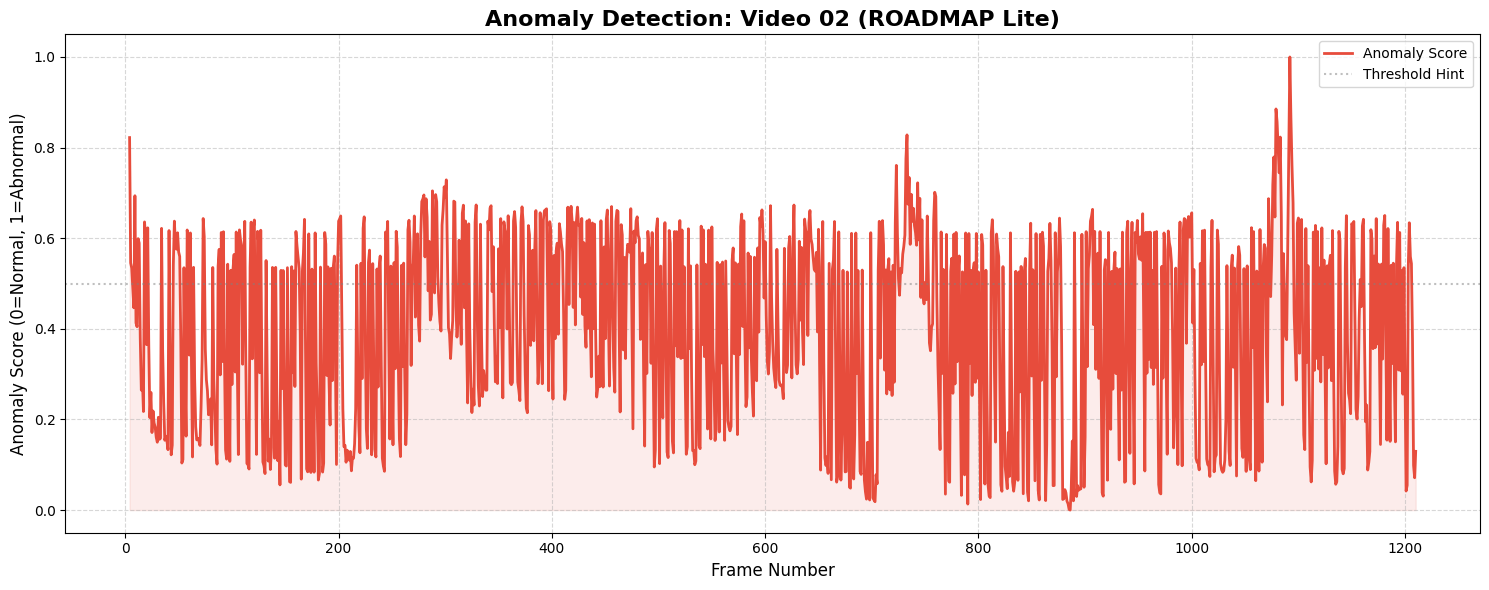

In [6]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS
CLEAN_TEST_DIR = '/kaggle/working/cleaned_testing_videos' 

# 2. Path to your saved LITE model
MODEL_PATH = 'roadmap_lite_model.pth'

IMG_SIZE = 256
T_STEPS = 4  # Must match what you trained with
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. RE-DEFINE ARCHITECTURE (Must match training exactly) ---
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1, stride, 0)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = out + self.shortcut(x) 
        return F.relu(out)

class ConvGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 2 * hidden_dim, kernel_size, 1, self.padding, bias=bias)
    def forward(self, input_tensor, cur_state):
        if cur_state is None:
            cur_state = torch.zeros(input_tensor.size(0), self.hidden_dim, input_tensor.size(2), input_tensor.size(3)).to(input_tensor.device)
        combined = torch.cat([input_tensor, cur_state], dim=1)
        combined_conv = self.conv(combined)
        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)
        new_state = (1 - update_gate) * cur_state + update_gate * torch.tanh(input_tensor)
        return new_state

class ROADMAP_LITE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 64, 3, 1, 1); self.enc2 = ResBlock(64, 128, 2)
        self.enc3 = ResBlock(128, 256, 2); self.enc4 = ResBlock(256, 512, 2)
        
        # Lite Paths (Direct GRU)
        self.gru1 = ConvGRUCell(512, 512, 3, True)
        self.gru2 = ConvGRUCell(256, 256, 3, True)
        self.gru3 = ConvGRUCell(128, 128, 3, True)
        
        self.dec1 = ResBlock(512 + 256, 256, 1); self.dec2 = ResBlock(256 + 128, 128, 1)
        self.dec3 = ResBlock(128 + 64, 64, 1); self.final = nn.Conv2d(64, 3, 3, 1, 1)

    def forward(self, frames):
        batch, t_steps, c, h, w = frames.size()
        h1, h2, h3 = None, None, None
        for t in range(t_steps):
            xt = frames[:, t]
            f1 = F.relu(self.enc1(xt)); f2 = self.enc2(f1)
            f3 = self.enc3(f2); f4 = self.enc4(f3)
            h1 = self.gru1(f4, h1); h2 = self.gru2(f3, h2); h3 = self.gru3(f2, h3)
            
        up1 = F.interpolate(h1, scale_factor=2); cat1 = torch.cat([up1, h2], dim=1); d1 = self.dec1(cat1)
        up2 = F.interpolate(d1, scale_factor=2); cat2 = torch.cat([up2, h3], dim=1); d2 = self.dec2(cat2)
        up3 = F.interpolate(d2, scale_factor=2); cat3 = torch.cat([up3, f1], dim=1); d3 = self.dec3(cat3)
        return torch.tanh(self.final(d3))

# --- 2. PSNR CALCULATION FUNCTION ---
def calc_psnr(pred, target):
    # Denormalize first: tanh output is [-1, 1] -> [0, 1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    
    mse = torch.mean((pred - target) ** 2, dim=[1, 2, 3]) # Mean per image
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# --- 3. MAIN VISUALIZATION FUNCTION ---
def visualize_video(vid_id):
    print(f"Visualizing Video: {vid_id}")
    
    # Locate Video
    vid_path = os.path.join(CLEAN_TEST_DIR, str(vid_id).zfill(2)) # Handle "1" vs "01"
    if not os.path.exists(vid_path):
        # Try finding folder regardless of leading zero
        candidates = [d for d in os.listdir(CLEAN_TEST_DIR) if str(int(d)) == str(int(vid_id))]
        if not candidates:
            print(f"Error: Video {vid_id} not found in {CLEAN_TEST_DIR}")
            return
        vid_path = os.path.join(CLEAN_TEST_DIR, candidates[0])
        
    frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
    print(f"Found {len(frames)} frames.")
    
    # Load Model
    model = ROADMAP_LITE()
    if os.path.exists(MODEL_PATH):
        state = torch.load(MODEL_PATH, map_location=DEVICE)
        # Handle DataParallel cleaning
        new_state = {k.replace('module.', ''): v for k, v in state.items()}
        model.load_state_dict(new_state)
    else:
        print("Model file not found!")
        return
    
    model.to(DEVICE)
    model.eval()
    
    # Transform
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    
    psnr_list = []
    frame_indices = []
    
    print("Running Inference...")
    with torch.no_grad():
        for i in range(len(frames) - T_STEPS):
            # Input: T frames
            clip = frames[i : i + T_STEPS]
            # Target: The NEXT frame (T+1)
            target_path = frames[i + T_STEPS]
            
            input_imgs = [tf(Image.open(p).convert('RGB')) for p in clip]
            target_img = tf(Image.open(target_path).convert('RGB')).unsqueeze(0).to(DEVICE)
            
            input_tensor = torch.stack(input_imgs).unsqueeze(0).to(DEVICE) # (1, T, 3, H, W)
            
            # Predict
            pred_img = model(input_tensor)
            
            # Calculate Quality (PSNR)
            psnr = calc_psnr(pred_img, target_img)
            psnr_list.append(psnr)
            frame_indices.append(i + T_STEPS) # Mapping to the predicted frame index
            
    # --- 4. NORMALIZE TO ANOMALY SCORE ---
    # Paper Formula: S_t = 1 - (R_t - min(R)) / (max(R) - min(R)) 
    psnr_array = np.array(psnr_list)
    min_r = np.min(psnr_array)
    max_r = np.max(psnr_array)
    
    # Inverse: Low PSNR (Bad prediction) -> High Anomaly Score
    anomaly_scores = 1.0 - ((psnr_array - min_r) / (max_r - min_r))
    
    # --- 5. PLOT ---
    plt.figure(figsize=(15, 6))
    
    # Plot the signal
    plt.plot(frame_indices, anomaly_scores, color='#e74c3c', linewidth=2, label='Anomaly Score')
    
    # Add styling
    plt.title(f'Anomaly Detection: Video {vid_id} (ROADMAP Lite)', fontsize=16, fontweight='bold')
    plt.xlabel('Frame Number', fontsize=12)
    plt.ylabel('Anomaly Score (0=Normal, 1=Abnormal)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='Threshold Hint')
    
    # Fill under curve for emphasis
    plt.fill_between(frame_indices, anomaly_scores, color='#e74c3c', alpha=0.1)
    
    plt.legend()
    plt.tight_layout()
    
    # Save and Show
    save_name = f'anomaly_plot_video_{vid_id}.png'
    plt.savefig(save_name)
    print(f"Plot saved to {save_name}")
    plt.show()

# ==========================================
# ENTER VIDEO NUMBER HERE
# ==========================================
target_video = "09"  # <--- Change this to whatever video you wish (e.g., "01", "12")
visualize_video(target_video)